In [5]:
from collections import defaultdict
from functools import reduce
from itertools import product, combinations
from time import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [89]:
seed = 42
alpha = .01


def reset_data_and_parameters(n_units=3, n_obs=100):
    np.random.seed(seed)
    
    # initialize data
    data = np.random.binomial(n=1, p=[.8, .1, .5], size=(100, n_units))
    
    # initialize parameters
    biases = np.random.randn(n_units)
    weights = np.random.randn(n_units, n_units)
    
    # a few other pieces we'll need
    var_combinations = list(combinations(range(n_units), 2))
    all_configs = list(product([0, 1], repeat=n_units))
    
    return weights, biases, var_combinations, all_configs, data


class Model:
    
    def __init__(self, weights, biases, var_combinations, all_configs):
        self.weights = weights
        self.biases = biases
        self.var_combinations = var_combinations
        self.all_configs = all_configs
        self.n_units = len(self.biases)
        
    def H(self, x):
        h = 0
        for i, j in self.var_combinations:
            h += self.weights[i, j] * x[i] * x[j]
        h += self.biases @ x
        return h
    
    def _unnormalized_likelihood(self, x):
        return np.exp(self.H(x))
    
    def marginal_likelihood(self, x):
        unnormalized_lik = 0
        for config in product(*[[0, 1] if el == ... else [el] for el in x]):
            config = np.array(config)
            unnormalized_lik += np.exp(self.H(config))
        return unnormalized_lik
    
    def likelihood(self, x, log=False):
        """
        Must have the dimensionality of the data observations. To marginalize, put ellipses (...)
        in the elements over which you wish to marginalize.
        """
        x = np.array(x)
        if not self.n_units in x.shape and len(x.shape) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        # compute partition function
        Z = sum([self._unnormalized_likelihood(config) for config in self.all_configs])
        
        if log:
            return sum([np.log(lik) - np.log(Z) for lik in likelihood])
        else:
            return reduce(np.multiply, [lik / Z for lik in likelihood])
    
    def conditional_likelihood(x, cond: dict):
        joint = np.array(x)
        for index, val in cond.items():
            if isinstance(joint[index], int):
                raise
            joint[index] = val

        evidence = [cond.get(i, ...) for i in range(len(x))]

        return self._unnormalized_likelihood(joint) / self.marginal_likelihood(evidence)

# sample from model

In [90]:
def inv_logit(z):
    return 1 / (1 + np.exp(-z))


def gibbs_sampler(weights, biases, init_sample=None, n_samples=100, burn_in=25, every_n=10) -> np.array:
    
    np.random.seed(seed)
    
    if burn_in > n_samples:
        raise("Can't burn in for more samples than there are in the chain")
        
    init_sample = init_sample or [0 for _ in biases]
    samples = [init_sample]
    
    def _gibbs_step(sample, i):
        z = sum([weights[i, j] * sample[j] for j in range(len(sample)) if j != i]) + biases[i]
        p = inv_logit(z)
        return np.random.binomial(n=1, p=p)
    
    for _ in range(n_samples):
        sample = list(samples[-1])  # make copy
        for i, _ in enumerate(sample):
            sample[i] = _gibbs_step(sample=sample, i=i)
        samples.append( sample )
        
    return np.array([sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0])

# update parameters

In [91]:
# using full model expectation to compute negative phase
def update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=alpha):
    model = Model(weights, biases, var_combinations, all_configs)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

# train model

In [92]:
weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=3)


for i in range(100):
    weights, biases = update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=.1)
    
    lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)

-228.68252851025792
-208.97809892560977
-194.12833944101587
-183.41091547023356
-176.03047042615046
-171.11653961478015
-167.8938808376056
-165.77637181658392
-164.36473399799024
-163.40223080001067


# plot samples

In [93]:
def plot_n_samples(n, weights=weights, biases=biases):
    """
    TODO: put some axes on this thing and maybe label corners.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    samples = gibbs_sampler(n_samples=n, weights=weights, biases=biases)
    x, y, z = zip(*np.array(samples))
    
    x += np.random.randn(len(x)) * .02
    y += np.random.randn(len(y)) * .02
    z += np.random.randn(len(z)) * .02
    
    ax.scatter(x, y, z)

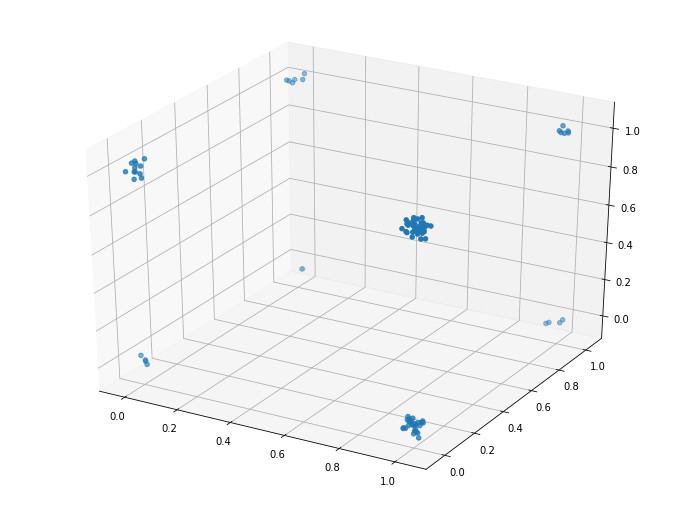

In [94]:
plot_n_samples(1000)

# now, derivation of gradient updates

# compare true distribution with gibbs chain

In [95]:
model = Model(weights, biases, var_combinations, all_configs)

distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]
distribution

[(array([0, 0, 0]), 0.0683918315486422),
 (array([0, 0, 1]), 0.11177885956546824),
 (array([0, 1, 0]), 0.0372833409371245),
 (array([0, 1, 1]), 0.030794838040037926),
 (array([1, 0, 0]), 0.287893486196494),
 (array([1, 0, 1]), 0.3951156451720047),
 (array([1, 1, 0]), 0.04058962222438993),
 (array([1, 1, 1]), 0.02815237631583858)]

In [96]:
model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=1000)

empirical_dist = defaultdict(int)
for sample in model_samples:
    empirical_dist[tuple(sample)] += 1 / len(model_samples)
    
empirical_dist  

defaultdict(int,
            {(1, 0, 0): 0.2653061224489797,
             (1, 0, 1): 0.3877551020408166,
             (0, 0, 1): 0.12244897959183672,
             (1, 1, 0): 0.04081632653061224,
             (1, 1, 1): 0.06122448979591836,
             (0, 1, 0): 0.02040816326530612,
             (0, 0, 0): 0.04081632653061224,
             (0, 1, 1): 0.06122448979591836})

In [97]:
for val, prob in distribution:
    empirical_prob = empirical_dist[tuple(val)]
    print(f'Value: {val}')
    print(f'True probability: {prob}')
    print(f'Empirical probability: {empirical_prob}')
    print(f'Abs difference: {np.abs(prob - empirical_prob)}')
    print('\n')

Value: [0 0 0]
True probability: 0.0683918315486422
Empirical probability: 0.04081632653061224
Abs difference: 0.02757550501802996


Value: [0 0 1]
True probability: 0.11177885956546824
Empirical probability: 0.12244897959183672
Abs difference: 0.010670120026368482


Value: [0 1 0]
True probability: 0.0372833409371245
Empirical probability: 0.02040816326530612
Abs difference: 0.01687517767181838


Value: [0 1 1]
True probability: 0.030794838040037926
Empirical probability: 0.06122448979591836
Abs difference: 0.030429651755880433


Value: [1 0 0]
True probability: 0.287893486196494
Empirical probability: 0.2653061224489797
Abs difference: 0.0225873637475143


Value: [1 0 1]
True probability: 0.3951156451720047
Empirical probability: 0.3877551020408166
Abs difference: 0.007360543131188113


Value: [1 1 0]
True probability: 0.04058962222438993
Empirical probability: 0.04081632653061224
Abs difference: 0.00022670430622231258


Value: [1 1 1]
True probability: 0.02815237631583858
Empirical 

# compare sampling algorithms

In [99]:
# using the expectation of gibbs samples to approximate negative phase

def update_parameters_with_gibbs_sampling(weights, biases, var_combinations, data, n_samples=100, alpha=alpha, **kwargs):
    model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=n_samples)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

## via approximating negative phase via gibbs sampling

In [101]:
all_updates = []

In [102]:
def train_model_for_n_epochs(optim_algo, n_units=3, epochs=100, alpha=alpha):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units)

    timestamps, updates = [], []
    for i in range(epochs):
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha
        )
        
        elapsed = timestamps[-1] - timestamps[0]

        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if i % 10 == 0:
            print(f'Epoch: {i} | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'step': i, 'time': elapsed})
        
    return pd.DataFrame(updates)

In [103]:
updates = train_model_for_n_epochs(update_parameters_with_gibbs_sampling, epochs=100)

all_updates.append(updates)

Epoch: 0 | Likelihood: -230.78645885668317
Epoch: 10 | Likelihood: -229.0934287488415
Epoch: 20 | Likelihood: -227.45115302818857
Epoch: 30 | Likelihood: -225.85940984582854
Epoch: 40 | Likelihood: -224.31794137161435
Epoch: 50 | Likelihood: -222.8264550883044
Epoch: 60 | Likelihood: -221.384625199381
Epoch: 70 | Likelihood: -220.03889892923755
Epoch: 80 | Likelihood: -218.8303308437581
Epoch: 90 | Likelihood: -217.6211487898242


## via computing true negative phase

In [104]:
updates = train_model_for_n_epochs(update_parameters_with_true_negative_phase)

all_updates.append(updates)

Epoch: 0 | Likelihood: -230.72958024200875
Epoch: 10 | Likelihood: -228.4729054438012
Epoch: 20 | Likelihood: -226.27514964395408
Epoch: 30 | Likelihood: -224.13459201818955
Epoch: 40 | Likelihood: -222.04970140254892
Epoch: 50 | Likelihood: -220.0191124362034
Epoch: 60 | Likelihood: -218.04160344272393
Epoch: 70 | Likelihood: -216.11607603204635
Epoch: 80 | Likelihood: -214.24153638582257
Epoch: 90 | Likelihood: -212.41707817533427


In [105]:
df = pd.concat(all_updates)

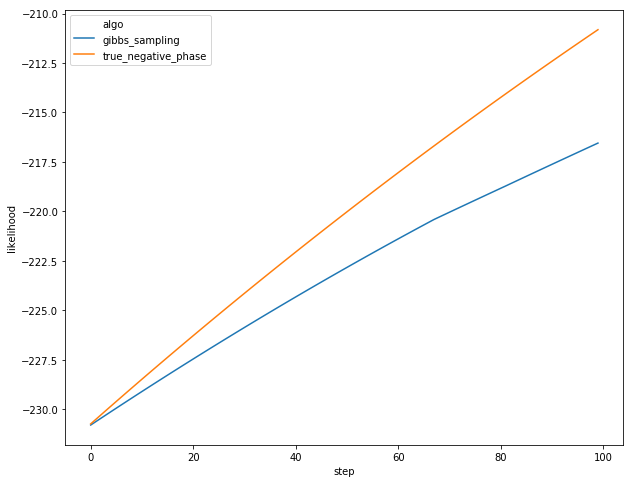

In [106]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="step", y="likelihood", hue="algo", legend='brief', data=df, ci=None)

# run both for 10 seconds

In [133]:
def train_model_for_n_seconds(optim_algo, n_units=3, seconds=10, alpha=alpha):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units)

    elapsed = 0
    timestamps, updates = [], []
    
    while elapsed < seconds:
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha
        )
        
        elapsed = timestamps[-1] - timestamps[0]
        
        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if len(timestamps) > 1 and int(timestamps[-1]) - int(timestamps[-2]) > 0:
            print(f'Elapsed: {elapsed:.2}s | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'elapsed': elapsed} )
        
    return pd.DataFrame(updates)

## via approximating negative phase via gibbs sampling

In [134]:
all_updates = []

In [135]:
updates = train_model_for_n_seconds(update_parameters_with_gibbs_sampling, seconds=10, alpha=.001)

all_updates.append(updates)

Elapsed: 0.86s | Likelihood: -228.76091982494748
Elapsed: 1.9s | Likelihood: -226.25262171287358
Elapsed: 2.9s | Likelihood: -223.74530562111684
Elapsed: 3.9s | Likelihood: -221.51236556308405
Elapsed: 4.9s | Likelihood: -219.39808020005938
Elapsed: 5.9s | Likelihood: -217.4405607589083
Elapsed: 6.9s | Likelihood: -215.53872071998998
Elapsed: 7.9s | Likelihood: -213.7467214129902
Elapsed: 8.9s | Likelihood: -211.93605562161974
Elapsed: 9.9s | Likelihood: -210.08835396627228


In [136]:
df = pd.DataFrame(updates)

## via computing true negative phase

In [138]:
updates = train_model_for_n_seconds(update_parameters_with_true_negative_phase, seconds=10, alpha=.001)

all_updates.append(updates)

Elapsed: 0.61s | Likelihood: -226.77789763812362
Elapsed: 1.6s | Likelihood: -221.13459408623964
Elapsed: 2.6s | Likelihood: -217.48493133029476
Elapsed: 3.6s | Likelihood: -213.58779346084077
Elapsed: 4.6s | Likelihood: -207.9299520503343
Elapsed: 5.6s | Likelihood: -202.50714772103245
Elapsed: 6.6s | Likelihood: -197.5093662948644
Elapsed: 7.6s | Likelihood: -193.0752619625944
Elapsed: 8.6s | Likelihood: -189.08337363262032
Elapsed: 9.6s | Likelihood: -185.6202061292543


In [139]:
df = pd.DataFrame(updates)

In [149]:
df = pd.concat(all_updates)

In [152]:
df['algo'].value_counts()

true_negative_phase    3012
gibbs_sampling         1587
Name: algo, dtype: int64

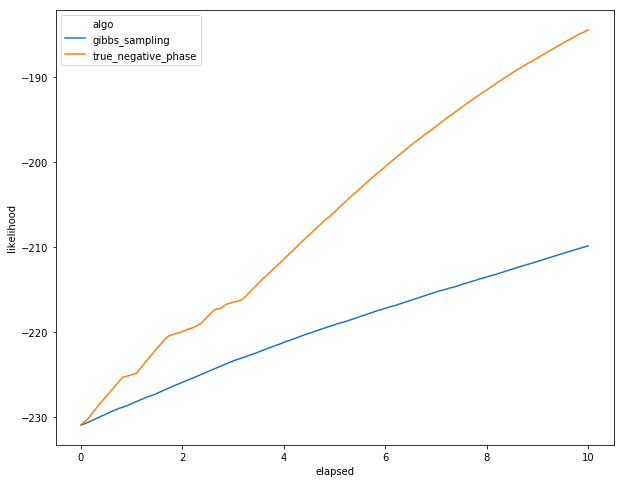

In [154]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="elapsed", y="likelihood", hue="algo", legend='brief', data=df, ci=None)

In [114]:
# multiple runs per n_units

# ablation of n_units